In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cmocean
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

# Summary 

This notebook opens up the NOBM-OASIM dataset with the added PC scores, standardizes all the environmental variables, and creates new datasets for each phyto group > 0.01 with added logged phyto concentrations. Then, data is split into training and testing and for each phyto group, a backward stepwise regression is used to select most important variables (PC scores and env variables). Selected variables, coefficients, and the int are saved as a .csv for each. 


# Read in dataset w/ scores

In [3]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_scores.nc', decode_times=False)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/55)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    PC_3            (months, lat, lon) float64 ...
    PC_4            (months, lat, lon) float64 ...
    PC_5            (months, lat, lon) float64 ...
    PC_6            (months, lat, lon) float64 ...
    PC_7            (months, lat, lon) float64 ...
    PC_8            (months, lat, lon) float64 ...

# Standardize env variables (values range from 0-1)

In [4]:
env_vars = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(len(env_vars)):
    foo = rrs_xds[env_vars[i]].values.reshape(12*234*288)
    foo = scaler.fit_transform(foo.reshape(-1, 1))
    rrs_xds[env_vars[i]].values = foo.reshape(12,234,288)

# Convert data into pandas dataframe

In [5]:
variables = list(rrs_xds.keys())[0:18]
variables.extend(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555'])
variables.extend(list(rrs_xds.keys())[47:68])
variables.remove("ice")

rrs_xds_dat = rrs_xds[variables].to_dataframe()
rrs_xds_dat

tot  chl  dia  coc  cya  din  pha  pic  irn  rno  \
months lat        lon                                                         
0.0    -84.000000 -180.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11.0    71.333336  173.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           ...  a_cdoc_443  bbp_s_440_555  PC_1  PC_2  PC_3  \
months lat        lon      ...                                                
0.0    -84.000000 -180.00  ...         NaN            NaN   0.0   0.0   0.0   
                  -178.75  ...         NaN            NaN   0.0   0.0   0.0   
                  -177.50  ...         NaN            NaN   0.0   0.0   0.0   
                  -176.25  ...         NaN            NaN   0.0   0.0   0.0   
                  -175.00  ...         NaN            NaN   0.0   0.0   0.0   
...                        ...         ...            ...   ...   ...   ...   
11.0    71.333336  173.75  ...         NaN            NaN   0.0   0.0   0.0   
                   175.00  ...         NaN            NaN   0.0   0.0   0.0   
                   176.25  ...         NaN            NaN   0.0   0.0   0.0   
                   177.50  ...         NaN            NaN   0.0   0.0   0.0   
                   178.75  ...         NaN            NaN   0.0   0.0   0.0   

                           PC_4  PC_5  PC_6  PC_7  PC_8  
months lat        lon                                    
0.0    -84.000000 -180.00   0.0   0.0   0.0   0.0   0.0  
                  -178.75   0.0   0.0   0.0   0.0   0.0  
                  -177.50   0.0   0.0   0.0   0.0   0.0  
                  -176.25   0.0   0.0   0.0   0.0   0.0  
                  -175.00   0.0   0.0   0.0   0.0   0.0  
...                         ...   ...   ...   ...   ...  
11.0    71.333336  173.75   0.0   0.0   0.0   0.0   0.0  
                   175.00   0.0   0.0   0.0   0.0   0.0  
                   176.25   0.0   0.0   0.0   0.0   0.0  
                   177.50   0.0   0.0   0.0   0.0   0.0  
                   178.75   0.0   0.0   0.0   0.0   0.0  

[808704 rows x 29 columns]

# drop nans for SequentialFeatureSelector function

In [6]:
rrs_xds_dat = rrs_xds_dat.dropna()
rrs_xds_dat

tot           chl           dia           coc  \
months lat        lon                                                           
0.0    -78.000000 -180.00  0.435280  1.302277e-32  5.790093e-08  1.836052e-12   
                  -178.75  0.442183  1.800597e-32  9.011884e-08  3.257872e-12   
                  -177.50  0.481909  2.523838e-32  1.144635e-07  3.826336e-12   
                  -176.25  0.488594  3.730429e-32  1.733026e-07  5.143830e-12   
                  -175.00  0.497206  6.912371e-32  2.431619e-07  7.160853e-12   
...                             ...           ...           ...           ...   
11.0    70.666664  11.25   0.012477  3.297888e-26  9.077619e-03  3.398656e-03   
                   12.50   0.012505  3.692610e-27  9.195263e-03  3.309032e-03   
                   13.75   0.012494  4.220176e-28  9.203578e-03  3.290530e-03   
                   15.00   0.012181  6.779949e-29  9.030103e-03  3.151193e-03   
                   16.25   0.012571  1.280946e-29  9.533199e-03  3.037988e-03   

                                    cya           din           pha       pic  \
months lat        lon                                                           
0.0    -78.000000 -180.00  6.897307e-27  2.209340e-32  4.352803e-01  0.087553   
                  -178.75  1.139934e-26  3.322602e-32  4.421830e-01  0.084408   
                  -177.50  2.645717e-26  3.457083e-32  4.819090e-01  0.082188   
                  -176.25  3.336013e-26  4.394092e-32  4.885941e-01  0.037648   
                  -175.00  6.450341e-26  5.779970e-32  4.972054e-01  0.037325   
...                                 ...           ...           ...       ...   
11.0    70.666664  11.25   2.053559e-32  6.851186e-07  1.198069e-16  0.034525   
                   12.50   2.029524e-32  4.639312e-07  8.584605e-18  0.033835   
                   13.75   2.029467e-32  2.601123e-07  4.475222e-19  0.033764   
                   15.00   2.029227e-32  1.060638e-07  2.997065e-20  0.032094   
                   16.25   2.034517e-32  4.291214e-08  2.179896e-21  0.029447   

                                irn       rno  ...  a_cdoc_443  bbp_s_440_555  \
months lat        lon                          ...                              
0.0    -78.000000 -180.00  0.007332  0.201124  ...    0.012361       1.468672   
                  -178.75  0.006864  0.196557  ...    0.014316       1.461740   
                  -177.50  0.007734  0.213100  ...    0.016593       1.445815   
                  -176.25  0.007556  0.221613  ...    0.033314       1.327958   
                  -175.00  0.007825  0.228030  ...    0.033840       1.324890   
...                             ...       ...  ...         ...            ...   
11.0    70.666664  11.25   0.023712  0.263522  ...    0.016708       1.656894   
                   12.50   0.022787  0.258618  ...    0.016709       1.656871   
                   13.75   0.022105  0.255697  ...    0.016710       1.657081   
                   15.00   0.024089  0.287036  ...    0.016710       1.657078   
                   16.25   0.019779  0.243204  ...    0.016712       1.652229   

                               PC_1      PC_2      PC_3      PC_4      PC_5  \
months lat        lon                                                         
0.0    -78.000000 -180.00  1.360266 -0.191872 -0.897007 -0.420749  1.557226   
                  -178.75  1.324405 -0.234275 -0.944701 -0.471543  1.505242   
                  -177.50  1.286334 -0.277437 -0.992318 -0.523330  1.450917   
                  -176.25  1.088890 -0.500141 -1.230536 -0.763205  1.232905   
                  -175.00  1.085033 -0.505047 -1.235329 -0.768063  1.228512   
...                             ...       ...       ...       ...       ...   
11.0    70.666664  11.25   1.237665 -0.349772 -1.066330 -0.573227  1.465386   
                   12.50   1.236489 -0.350209 -1.067340 -0.574370  1.464955   
                   13.75   1.236332 -0.350629 -1.067371 -0.575595  1.464647   
 

# Make new datasets that filter phyto conc less than 0.01

In [7]:
tot_dat = rrs_xds_dat[rrs_xds_dat.tot > 0.01]
chl_dat = rrs_xds_dat[rrs_xds_dat.chl > 0.01]
dia_dat = rrs_xds_dat[rrs_xds_dat.dia > 0.01]
coc_dat = rrs_xds_dat[rrs_xds_dat.coc > 0.01]
cya_dat = rrs_xds_dat[rrs_xds_dat.cya > 0.01]
din_dat = rrs_xds_dat[rrs_xds_dat.din > 0.01]
pha_dat = rrs_xds_dat[rrs_xds_dat.pha > 0.01]

# Make new variables of logged phyto groups

In [8]:
tot_dat['log_tot'] = np.log10(tot_dat.tot)
chl_dat['log_chl'] = np.log10(chl_dat.chl)
dia_dat['log_dia'] = np.log10(dia_dat.dia)
coc_dat['log_coc'] = np.log10(coc_dat.coc)
cya_dat['log_cya'] = np.log10(cya_dat.cya)
din_dat['log_din'] = np.log10(din_dat.din)
pha_dat['log_pha'] = np.log10(pha_dat.pha)

In [9]:
print(len(tot_dat))
print(len(chl_dat))
print(len(dia_dat))
print(len(coc_dat))
print(len(cya_dat))
print(len(din_dat))
print(len(pha_dat))

472526
157374
205597
175987
221995
4804
92565


# Look at distribution of phyto group conc

<Axes: title={'center': 'log_pha'}, ylabel='Frequency'>

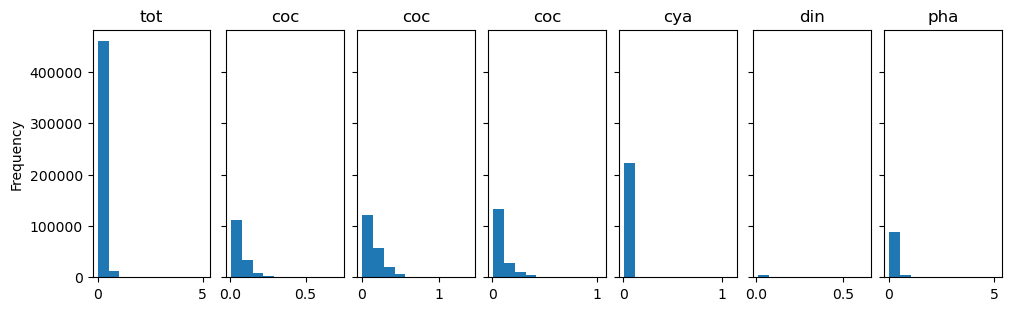

<Figure size 640x480 with 0 Axes>

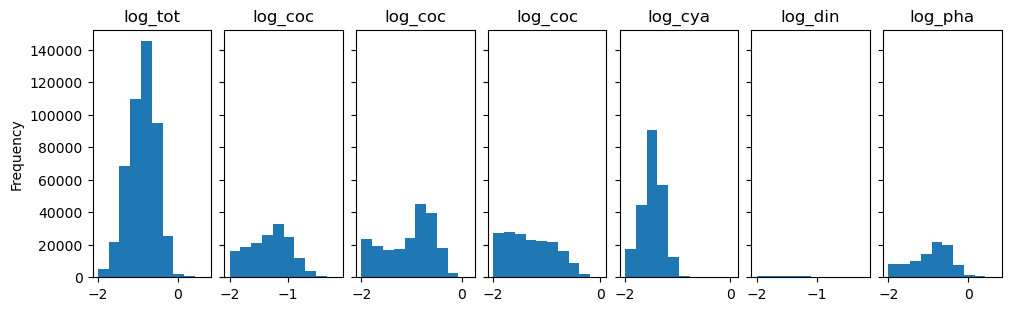

In [10]:
#histograms of phyto groups
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.tot.plot.hist(ax=axs[0], title='tot')
chl_dat.chl.plot.hist(ax=axs[1], title='coc')
dia_dat.dia.plot.hist(ax=axs[2], title='coc')
coc_dat.coc.plot.hist(ax=axs[3], title='coc')
cya_dat.cya.plot.hist(ax=axs[4], title='cya')
din_dat.din.plot.hist(ax=axs[5], title='din')
pha_dat.pha.plot.hist(ax=axs[6], title='pha')

#histograms of logged phyto groups
plt.figure(2)
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.log_tot.plot.hist(ax=axs[0], title='log_tot')
chl_dat.log_chl.plot.hist(ax=axs[1], title='log_coc')
dia_dat.log_dia.plot.hist(ax=axs[2], title='log_coc')
coc_dat.log_coc.plot.hist(ax=axs[3], title='log_coc')
cya_dat.log_cya.plot.hist(ax=axs[4], title='log_cya')
din_dat.log_din.plot.hist(ax=axs[5], title='log_din')
pha_dat.log_pha.plot.hist(ax=axs[6], title='log_pha')

# Correlation plot of phyto groups and env data/ PC scores

In [11]:
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

for i in range(len(phyto_vars)):
    rrs_xds_dat[phyto_vars[i]][rrs_xds_dat[phyto_vars[i]] < 0.01] = np.nan
rrs_xds_dat    

tot  chl  dia  coc  cya  din       pha  \
months lat        lon                                                    
0.0    -78.000000 -180.00  0.435280  NaN  NaN  NaN  NaN  NaN  0.435280   
                  -178.75  0.442183  NaN  NaN  NaN  NaN  NaN  0.442183   
                  -177.50  0.481909  NaN  NaN  NaN  NaN  NaN  0.481909   
                  -176.25  0.488594  NaN  NaN  NaN  NaN  NaN  0.488594   
                  -175.00  0.497206  NaN  NaN  NaN  NaN  NaN  0.497205   
...                             ...  ...  ...  ...  ...  ...       ...   
11.0    70.666664  11.25   0.012477  NaN  NaN  NaN  NaN  NaN       NaN   
                   12.50   0.012505  NaN  NaN  NaN  NaN  NaN       NaN   
                   13.75   0.012494  NaN  NaN  NaN  NaN  NaN       NaN   
                   15.00   0.012181  NaN  NaN  NaN  NaN  NaN       NaN   
                   16.25   0.012571  NaN  NaN  NaN  NaN  NaN       NaN   

                                pic       irn       rno  ...  a_cdoc_443  \
months lat        lon                                    ...               
0.0    -78.000000 -180.00  0.087553  0.007332  0.201124  ...    0.012361   
                  -178.75  0.084408  0.006864  0.196557  ...    0.014316   
                  -177.50  0.082188  0.007734  0.213100  ...    0.016593   
                  -176.25  0.037648  0.007556  0.221613  ...    0.033314   
                  -175.00  0.037325  0.007825  0.228030  ...    0.033840   
...                             ...       ...       ...  ...         ...   
11.0    70.666664  11.25   0.034525  0.023712  0.263522  ...    0.016708   
                   12.50   0.033835  0.022787  0.258618  ...    0.016709   
                   13.75   0.033764  0.022105  0.255697  ...    0.016710   
                   15.00   0.032094  0.024089  0.287036  ...    0.016710   
                   16.25   0.029447  0.019779  0.243204  ...    0.016712   

                           bbp_s_440_555      PC_1      PC_2      PC_3  \
months lat        lon                                                    
0.0    -78.000000 -180.00       1.468672  1.360266 -0.191872 -0.897007   
                  -178.75       1.461740  1.324405 -0.234275 -0.944701   
                  -177.50       1.445815  1.286334 -0.277437 -0.992318   
                  -176.25       1.327958  1.088890 -0.500141 -1.230536   
                  -175.00       1.324890  1.085033 -0.505047 -1.235329   
...                                  ...       ...       ...       ...   
11.0    70.666664  11.25        1.656894  1.237665 -0.349772 -1.066330   
                   12.50        1.656871  1.236489 -0.350209 -1.067340   
                   13.75        1.657081  1.236332 -0.350629 -1.067371   
                   15.00        1.657078  1.235222 -0.352707 -1.069395   
                   16.25        1.652229  1.232959 -0.355128 -1.072480   

                               PC_4      PC_5      PC_6      PC_7      PC_8  
months lat        lon                                                        
0.0    -78.000000 -180.00 -0.420749  1.557226 -0.797977  0.903110 -0.304623  
                  -178.75 -0.471543  1.505242 -0.857627  0.840572 -0.325603  
                  -177.50 -0.523330  1.450917 -0.917560  0.777221 -0.346979  
                  -176.25 -0.763205  1.232905 -1.186494  0.515267 -0.428469  
                  -175.00 -0.768063  1.228512 -1.191440  0.510048 -0.429928  
...                             ...       ...       ...       ...       ...  
11.0    70.666664  11.25  -0.573227  1.465386 -0.968971  0.768001 -0.338577  
                   12.50  -0.574370  1.464955 -0.969846  0.767691 -0.339083  
                   13.75  -0.575595  1.464647 -0.970073  0.767192 -0.338676  
                   15.00  -0.576664  1.464459 -0.971338  0.765944 -0.338541  
                   16.25  -0.578540  1.464563 -0.973915  0.765234 -0.338434  

[487726 rows x 29 columns]

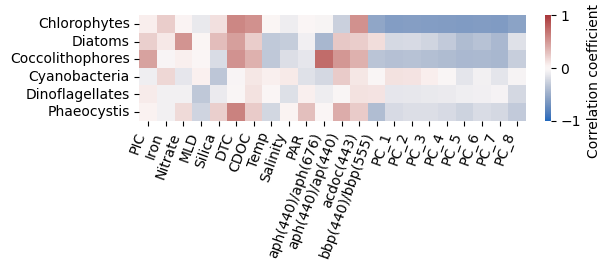

In [18]:
fig, axs = plt.subplots(figsize=(6,4), sharey=True, layout='compressed')

phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

env_vars = list(rrs_xds.keys())[7:18]
env_vars.extend(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555'])
env_vars.remove('ice')
env_vars.extend(['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8'])

sns.heatmap(rrs_xds_dat.corr().loc[phyto_vars[1:], env_vars], annot=False, vmin=-1, vmax=1,
            cmap='vlag', square=True, cbar_kws={'label': 'Correlation coefficient (R)'})

axs.set_yticklabels(['Chlorophytes', 'Diatoms', 'Coccolithophores', 'Cyanobacteria', 
                     'Dinoflagellates', 'Phaeocystis'], rotation=0)

axs.set_xticklabels(['PIC', 'Iron', 'Nitrate', 'MLD', 'Silica', 'DTC', 'CDOC', 'Temp', 
                     'Salinity', 'PAR', 'aph(440)/aph(676)', 'aph(440)/ap(440)', 
                     'acdoc(443)', 'bbp(440)/bbp(555)', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 
                     'PC_5', 'PC_6', 'PC_7', 'PC_8'], rotation=70, ha='right')

#plt.show()
plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/corr_plot.png', dpi=300) 


# For each phyto group:
- separate train, test, split data
- perform sequential feature selector to find most important variables
- perform k-fold cross validation to obtain predicted results and goodness of fit metrics
- plot actual vs predicted (logged and unlogged)
- save selected_features, mean coefs, mean int as .csv

TODO: change from 10 to 100 k-folds

# Total chlorophyll ('tot')

472526
(236263, 22)
(236263, 22)
(236263,)
(236263,)
Index(['pic', 'h', 'cdc', 't', 'aph440_aph676', 'aph440_ap440',
       'bbp_s_440_555', 'PC_1', 'PC_3', 'PC_5', 'PC_6'],
      dtype='object')
coefs: [  2.28334343   0.08878614  -1.09120091   0.10871109  -0.21545919
   2.40148717  -0.38525574  13.03377564 -22.14809176  -9.04265303
  15.97498775]
int: -11.421373723012257
mean r2: 0.9440155363454428
mean bias: 9.844560431331316e-06
mean mae: 0.05249114178297791


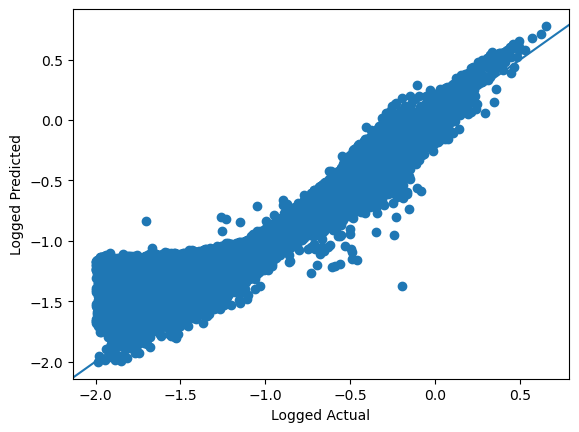

<Figure size 640x480 with 0 Axes>

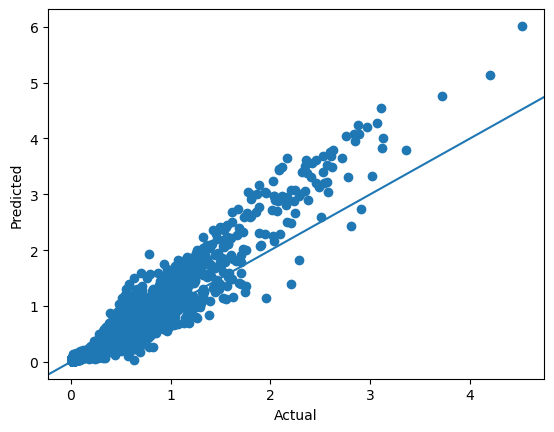

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score

tot_coefs_all = []
tot_intercept_all = []
tot_r2_scores = []
tot_bias_scores = []
tot_mae_scores = []

print(len(tot_dat))
# select columns that are x variables (all columns except phyto groups)
tot_dat_x = tot_dat.iloc[:,7:29]
#tot_dat_x_PC = tot_dat.iloc[:,21:29]

x_train, x_test, y_train, y_test = train_test_split(tot_dat_x, tot_dat.log_tot, 
                                                    test_size=0.5, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

tot_selected_features = sfs.fit(x_train, y_train)
tot_selected_features = x_train.loc[:, tot_selected_features.support_].columns
print(tot_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(tot_dat_x):

   # Split the data into training and test sets
    x_train, x_test = tot_dat_x.iloc[train_index], tot_dat_x.iloc[test_index]
    y_train, y_test = tot_dat.log_tot.iloc[train_index], tot_dat.log_tot.iloc[test_index]

    x_train_selected = x_train.loc[:, tot_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, tot_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    tot_coefs_all.append(coefs)
    tot_intercept_all.append(intercept)
    tot_r2_scores.append(r2score)
    tot_bias_scores.append(bias)
    tot_mae_scores.append(mae)
    
tot_coefs = np.mean(tot_coefs_all, axis=0)
print('coefs:', tot_coefs)
tot_int = np.mean(tot_intercept_all)
print('int:', tot_int)
tot_r2 = np.mean(tot_r2_scores)            
print('mean r2:', tot_r2)
tot_bias = np.mean(tot_bias_scores)
print('mean bias:', tot_bias)
tot_mae = np.mean(tot_mae_scores)
print('mean mae:', tot_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

tot = pd.DataFrame({'selected_features':tot_selected_features, 'coefs':tot_coefs, 
              'int':np.array([tot_int]*len(tot_selected_features))})
tot.to_csv('/glusteruser/awindled/tot.csv')

# Chlorophytes ('chl')

157374
min 0.010000105015933514
mean 0.06591216
max 0.7164859175682068
Index(['pic', 'rno', 'cdc', 't', 'aph440_ap440', 'bbp_s_440_555', 'PC_1',
       'PC_4', 'PC_5', 'PC_6', 'PC_8'],
      dtype='object')
coefs: [  6.61765824  -1.67645651  -1.55020609   1.15241399  -3.16052825
  -0.69528031  31.98973242 -95.83967598 -13.74755422  57.98006255
  40.52985882]
int: -5.566991239834796
mean r2: 0.781449642077275
mean bias: -0.0003468183086624317
mean mae: 0.11638164861992698


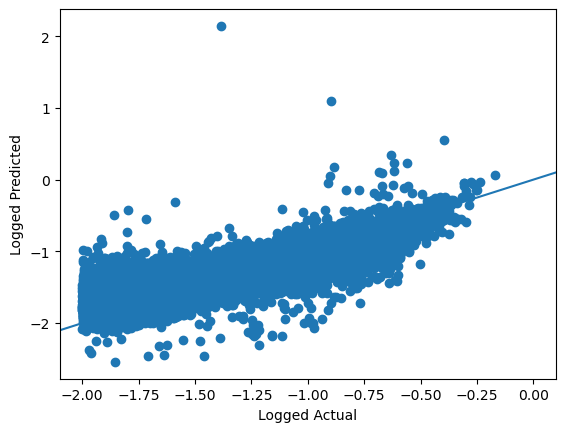

<Figure size 640x480 with 0 Axes>

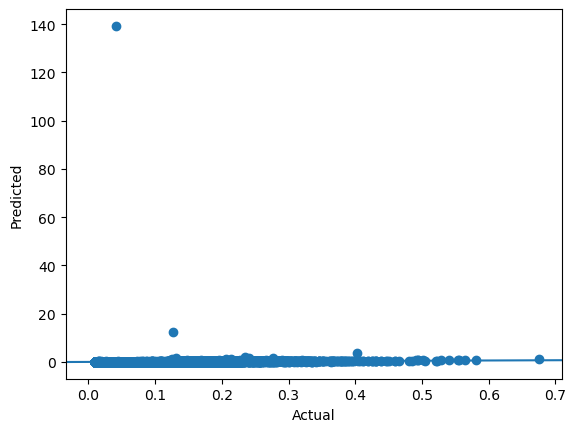

In [44]:
chl_coefs_all = []
chl_intercept_all = []
chl_r2_scores = []
chl_bias_scores = []
chl_mae_scores = []

print(len(chl_dat))
chl_dat_x = chl_dat.iloc[:,7:29]
print('min', chl_dat.chl.min())
print('mean', chl_dat.chl.mean())
print('max', chl_dat.chl.max())

x_train, x_test, y_train, y_test = train_test_split(chl_dat_x, chl_dat.log_chl, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

chl_selected_features = sfs.fit(x_train, y_train)
chl_selected_features = x_train.loc[:, chl_selected_features.support_].columns
print(chl_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(chl_dat_x):

   # Split the data into training and test sets
    x_train, x_test = chl_dat_x.iloc[train_index], chl_dat_x.iloc[test_index]
    y_train, y_test = chl_dat.log_chl.iloc[train_index], chl_dat.log_chl.iloc[test_index]

    x_train_selected = x_train.loc[:, chl_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, chl_selected_features])
    
    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    chl_coefs_all.append(coefs)
    chl_intercept_all.append(intercept)
    chl_r2_scores.append(r2score)
    chl_bias_scores.append(bias)
    chl_mae_scores.append(mae)
    
chl_coefs = np.mean(chl_coefs_all, axis=0)
print('coefs:', chl_coefs)
chl_int = np.mean(chl_intercept_all)
print('int:', chl_int)
chl_r2 = np.mean(chl_r2_scores)            
print('mean r2:', chl_r2)
chl_bias = np.mean(chl_bias_scores)
print('mean bias:', chl_bias)
chl_mae = np.mean(chl_mae_scores)
print('mean mae:', chl_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

chl = pd.DataFrame({'selected_features':chl_selected_features, 'coefs':chl_coefs, 
              'int':np.array([chl_int]*len(chl_selected_features))})
chl.to_csv('/glusteruser/awindled/chl.csv')

# Diatoms ('dia')

205597
min 0.010572781786322594
mean 0.24195607
max 3.312101364135742
Index(['pic', 'irn', 't', 's', 'aph440_aph676', 'aph440_ap440',
       'bbp_s_440_555', 'PC_1', 'PC_4', 'PC_5', 'PC_7'],
      dtype='object')
coefs: [  7.67903545  -4.25967247  -0.31975436   0.29726604  -0.56627445
   1.01643939   0.53476035 -14.36203687  12.47427499  35.06451595
 -34.27720214]
int: -1.385391927541157
mean r2: 0.8829541396819028
mean bias: -0.00020324857714111789
mean mae: 0.11778596474423413


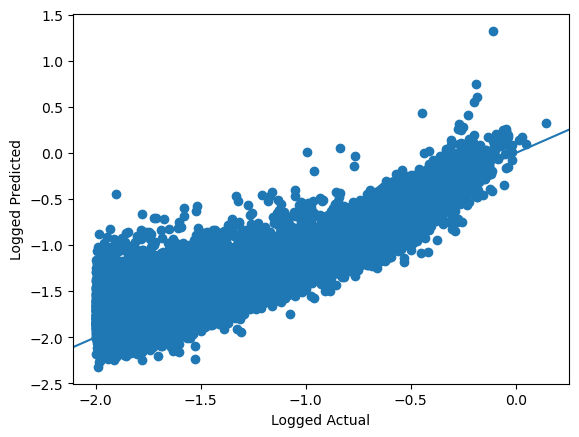

<Figure size 640x480 with 0 Axes>

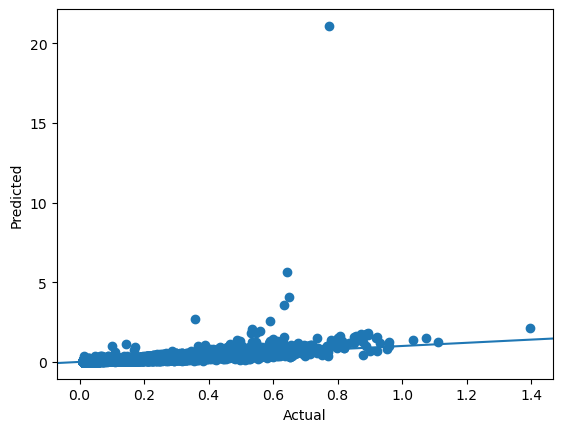

In [45]:
dia_coefs_all = []
dia_intercept_all = []
dia_r2_scores = []
dia_bias_scores = []
dia_mae_scores = []

print(len(dia_dat))
dia_dat_x = dia_dat.iloc[:,7:29]
print('min', dia_dat.tot.min())
print('mean', dia_dat.tot.mean())
print('max', dia_dat.tot.max())

x_train, x_test, y_train, y_test = train_test_split(dia_dat_x, dia_dat.log_dia, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

dia_selected_features = sfs.fit(x_train, y_train)
dia_selected_features = x_train.loc[:, dia_selected_features.support_].columns
print(dia_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(dia_dat_x):

   # Split the data into training and test sets
    x_train, x_test = dia_dat_x.iloc[train_index], dia_dat_x.iloc[test_index]
    y_train, y_test = dia_dat.log_dia.iloc[train_index], dia_dat.log_dia.iloc[test_index]

    x_train_selected = x_train.loc[:, dia_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, dia_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    dia_coefs_all.append(coefs)
    dia_intercept_all.append(intercept)
    dia_r2_scores.append(r2score)
    dia_bias_scores.append(bias)
    dia_mae_scores.append(mae)

dia_coefs = np.mean(dia_coefs_all, axis=0)
print('coefs:', dia_coefs)
dia_int = np.mean(dia_intercept_all)
print('int:', dia_int)
dia_r2 = np.mean(dia_r2_scores)            
print('mean r2:', dia_r2)
dia_bias = np.mean(dia_bias_scores)
print('mean bias:', dia_bias)
dia_mae = np.mean(dia_mae_scores)
print('mean mae:', dia_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

dia = pd.DataFrame({'selected_features':dia_selected_features, 'coefs':dia_coefs, 
              'int':np.array([dia_int]*len(dia_selected_features))})
dia.to_csv('/glusteruser/awindled/dia.csv')

# Coccolithophores ('coc')

175987
min 0.012777341529726982
mean 0.18747099
max 2.4403750896453857
Index(['pic', 'sil', 't', 's', 'aph440_aph676', 'aph440_ap440',
       'bbp_s_440_555', 'PC_4', 'PC_5', 'PC_7', 'PC_8'],
      dtype='object')
coefs: [ 1.16841787 -0.62672043 -0.14585283  0.10188928  0.38662266  2.00963072
 -0.33397277  0.13221747  2.3443505  -1.42747752 -4.53177602]
int: -6.287101184923034
mean r2: 0.9125479331557861
mean bias: 2.2770359338657544e-05
mean mae: 0.10313111618433286


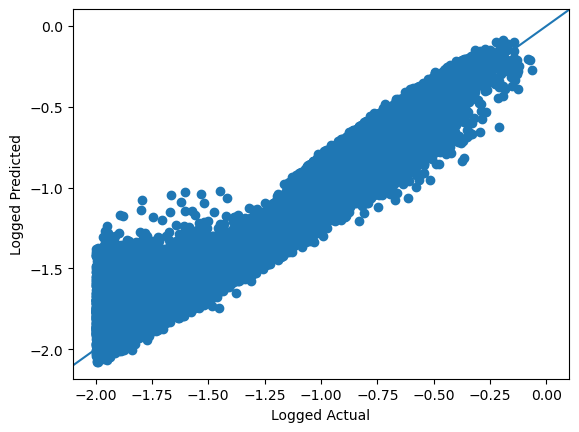

<Figure size 640x480 with 0 Axes>

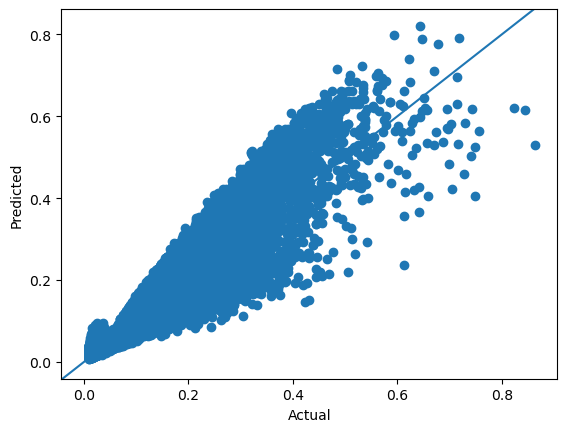

In [98]:
coc_coefs_all = []
coc_intercept_all = []
coc_r2_scores = []
coc_bias_scores = []
coc_mae_scores = []

print(len(coc_dat))
coc_dat_x = coc_dat.iloc[:,7:29]
print('min', coc_dat.tot.min())
print('mean', coc_dat.tot.mean())
print('max', coc_dat.tot.max())

x_train, x_test, y_train, y_test = train_test_split(coc_dat_x, coc_dat.log_coc, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

coc_selected_features = sfs.fit(x_train, y_train)
coc_selected_features = x_train.loc[:, coc_selected_features.support_].columns
print(coc_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(coc_dat_x):

   # Split the data into training and test sets
    x_train, x_test = coc_dat_x.iloc[train_index], coc_dat_x.iloc[test_index]
    y_train, y_test = coc_dat.log_coc.iloc[train_index], coc_dat.log_coc.iloc[test_index]

    x_train_selected = x_train.loc[:, coc_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, coc_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    coc_coefs_all.append(coefs)
    coc_intercept_all.append(intercept)
    coc_r2_scores.append(r2score)
    coc_bias_scores.append(bias)
    coc_mae_scores.append(mae)

coc_coefs = np.mean(coc_coefs_all, axis=0)
print('coefs:', coc_coefs)
coc_int = np.mean(coc_intercept_all)
print('int:', coc_int)
coc_r2 = np.mean(coc_r2_scores)            
print('mean r2:', coc_r2)
coc_bias = np.mean(coc_bias_scores)
print('mean bias:', coc_bias)
coc_mae = np.mean(coc_mae_scores)
print('mean mae:', coc_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

coc = pd.DataFrame({'selected_features':coc_selected_features, 'coefs':coc_coefs, 
              'int':np.array([coc_int]*len(coc_selected_features))})
coc.to_csv('/glusteruser/awindled/coc.csv')

# Cyanobacteria ('cya')

221995
min 0.012208417989313602
mean 0.09379212
max 1.1030681133270264
Index(['pic', 'rno', 'sil', 'dtc', 'aph440_aph676', 'aph440_ap440',
       'a_cdoc_443', 'PC_2', 'PC_5', 'PC_7', 'PC_8'],
      dtype='object')
coefs: [-7.83729945 -1.95257842 -0.81348675 -1.94181523 -0.09107258  1.59640234
 20.27315659  6.60326946 -8.84969623  7.44493768 -9.3633246 ]
int: 4.6002255674245855
mean r2: 0.9116323362078365
mean bias: -0.00010016131779069611
mean mae: 0.038686975260954805


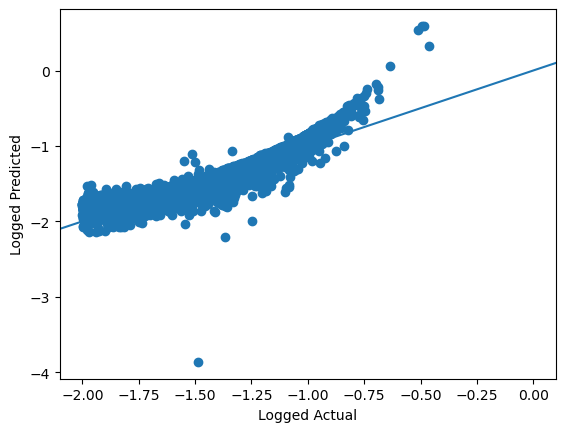

<Figure size 640x480 with 0 Axes>

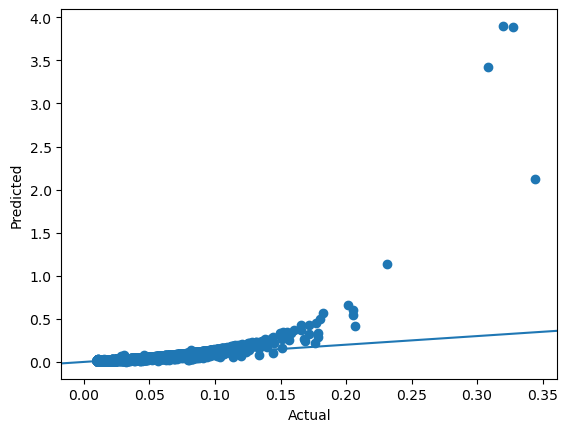

In [99]:
cya_coefs_all = []
cya_intercept_all = []
cya_r2_scores = []
cya_bias_scores = []
cya_mae_scores = []

print(len(cya_dat))
cya_dat_x = cya_dat.iloc[:,7:29]
print('min', cya_dat.tot.min())
print('mean', cya_dat.tot.mean())
print('max', cya_dat.tot.max())

x_train, x_test, y_train, y_test = train_test_split(cya_dat_x, cya_dat.log_cya, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

cya_selected_features = sfs.fit(x_train, y_train)
cya_selected_features = x_train.loc[:, cya_selected_features.support_].columns
print(cya_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(cya_dat_x):

   # Split the data into training and test sets
    x_train, x_test = cya_dat_x.iloc[train_index], cya_dat_x.iloc[test_index]
    y_train, y_test = cya_dat.log_cya.iloc[train_index], cya_dat.log_cya.iloc[test_index]

    x_train_selected = x_train.loc[:, cya_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, cya_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    cya_coefs_all.append(coefs)
    cya_intercept_all.append(intercept)
    cya_r2_scores.append(r2score)
    cya_bias_scores.append(bias)
    cya_mae_scores.append(mae)

cya_coefs = np.mean(cya_coefs_all, axis=0)
print('coefs:', cya_coefs)
cya_int = np.mean(cya_intercept_all)
print('int:', cya_int)
cya_r2 = np.mean(cya_r2_scores)            
print('mean r2:', cya_r2)
cya_bias = np.mean(cya_bias_scores)
print('mean bias:', cya_bias)
cya_mae = np.mean(cya_mae_scores)
print('mean mae:', cya_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

cya = pd.DataFrame({'selected_features':cya_selected_features, 'coefs':cya_coefs, 
              'int':np.array([cya_int]*len(cya_selected_features))})
cya.to_csv('/glusteruser/awindled/cya.csv')

# Dinoflagellates ('din')

4804
min 0.08068374544382095
mean 0.39016536
max 1.2372289896011353
Index(['h', 'dtc', 'par', 'aph440_aph676', 'aph440_ap440', 'a_cdoc_443',
       'bbp_s_440_555', 'PC_1', 'PC_2', 'PC_5', 'PC_7'],
      dtype='object')
coefs: [ -1.00514515   1.34605261  -0.11023889  -0.49415786   4.60808901
  14.09703382  -0.60581961  45.55675345 -45.8339542  -59.17628387
  55.50720253]
int: -29.013347565144954
mean r2: 0.5762950946540591
mean bias: 0.0034146099395286934
mean mae: 0.20468772056892467


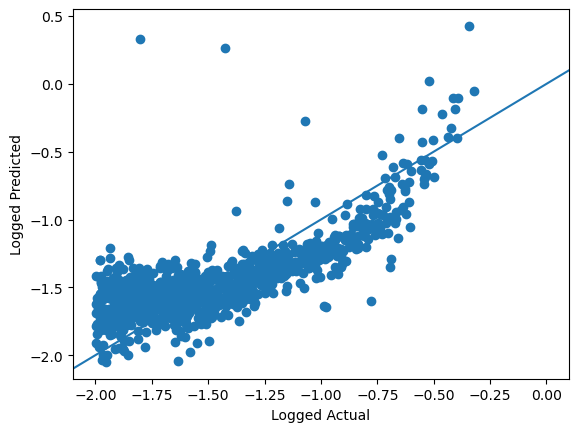

<Figure size 640x480 with 0 Axes>

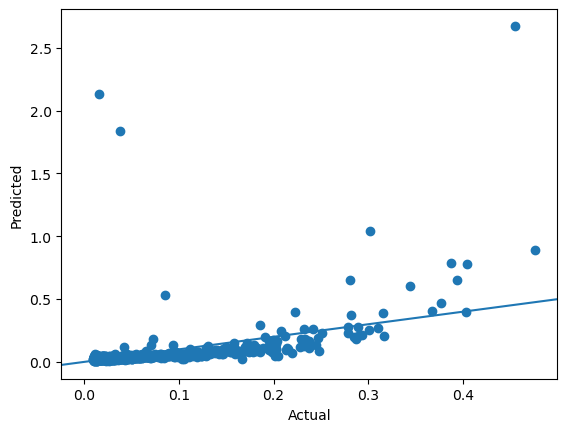

In [100]:
din_coefs_all = []
din_intercept_all = []
din_r2_scores = []
din_bias_scores = []
din_mae_scores = []

print(len(din_dat))
din_dat_x = din_dat.iloc[:,7:29]
print('min', din_dat.tot.min())
print('mean', din_dat.tot.mean())
print('max', din_dat.tot.max())

x_train, x_test, y_train, y_test = train_test_split(din_dat_x, din_dat.log_din, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

din_selected_features = sfs.fit(x_train, y_train)
din_selected_features = x_train.loc[:, din_selected_features.support_].columns
print(din_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(din_dat_x):

   # Split the data into training and test sets
    x_train, x_test = din_dat_x.iloc[train_index], din_dat_x.iloc[test_index]
    y_train, y_test = din_dat.log_din.iloc[train_index], din_dat.log_din.iloc[test_index]

    x_train_selected = x_train.loc[:, din_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, din_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    din_coefs_all.append(coefs)
    din_intercept_all.append(intercept)
    din_r2_scores.append(r2score)
    din_bias_scores.append(bias)
    din_mae_scores.append(mae)

din_coefs = np.mean(din_coefs_all, axis=0)
print('coefs:', din_coefs)
din_int = np.mean(din_intercept_all)
print('int:', din_int)
din_r2 = np.mean(din_r2_scores)            
print('mean r2:', din_r2)
din_bias = np.mean(din_bias_scores)
print('mean bias:', din_bias)
din_mae = np.mean(din_mae_scores)
print('mean mae:', din_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

din = pd.DataFrame({'selected_features':din_selected_features, 'coefs':din_coefs, 
              'int':np.array([din_int]*len(din_selected_features))})
din.to_csv('/glusteruser/awindled/din.csv')

# Phaeocystis ('pha')

92565
min 0.010001582093536854
mean 0.26200357
max 5.105597019195557
Index(['pic', 'h', 'dtc', 'cdc', 't', 'par', 'aph440_aph676', 'aph440_ap440',
       'PC_1', 'PC_5', 'PC_8'],
      dtype='object')
coefs: [ 5.69345526 -0.09539514  0.9870437  -3.20225632 -2.22736446  0.24192233
 -0.52763695  2.52994291 -9.03207416  6.07266267 -5.72342916]
int: 0.15262514926649398
mean r2: 0.845649395331668
mean bias: 0.00020094994843216748
mean mae: 0.14309776400596297


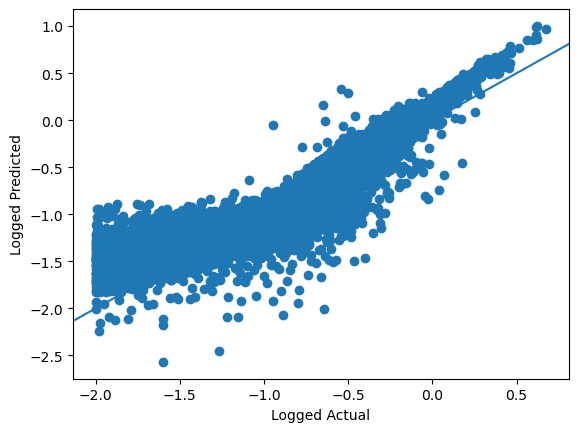

<Figure size 640x480 with 0 Axes>

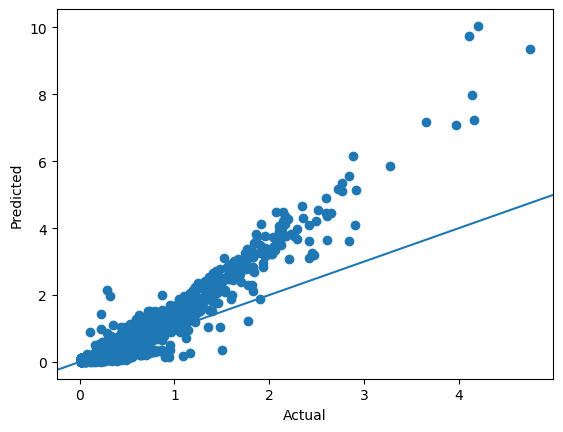

In [101]:
pha_coefs_all = []
pha_intercept_all = []
pha_r2_scores = []
pha_bias_scores = []
pha_mae_scores = []

print(len(pha_dat))
pha_dat_x = pha_dat.iloc[:,7:29]
print('min', pha_dat.tot.min())
print('mean', pha_dat.tot.mean())
print('max', pha_dat.tot.max())

x_train, x_test, y_train, y_test = train_test_split(pha_dat_x, pha_dat.log_pha, 
                                                    test_size=0.5, random_state=42)

sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                            n_features_to_select='auto',
                            direction='backward', scoring = 'r2', 
                            n_jobs=40, cv=5) 

pha_selected_features = sfs.fit(x_train, y_train)
pha_selected_features = x_train.loc[:, pha_selected_features.support_].columns
print(pha_selected_features)

kf = ShuffleSplit(n_splits=10, test_size=0.2)

for train_index, test_index in kf.split(pha_dat_x):

   # Split the data into training and test sets
    x_train, x_test = pha_dat_x.iloc[train_index], pha_dat_x.iloc[test_index]
    y_train, y_test = pha_dat.log_pha.iloc[train_index], pha_dat.log_pha.iloc[test_index]

    x_train_selected = x_train.loc[:, pha_selected_features]
    
    linreg=linear_model.LinearRegression()
    linreg.fit(x_train_selected, y_train)
    y_pred = linreg.predict(x_test.loc[:, pha_selected_features])

    coefs = linreg.coef_
    intercept = linreg.intercept_
    r2score = r2_score(y_test, y_pred)
    bias = np.nansum((y_pred - y_test))/len(y_test)
    mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
    
    pha_coefs_all.append(coefs)
    pha_intercept_all.append(intercept)
    pha_r2_scores.append(r2score)
    pha_bias_scores.append(bias)
    pha_mae_scores.append(mae)

pha_coefs = np.mean(pha_coefs_all, axis=0)
print('coefs:', pha_coefs)
pha_int = np.mean(pha_intercept_all)
print('int:', pha_int)
pha_r2 = np.mean(pha_r2_scores)            
print('mean r2:', pha_r2)
pha_bias = np.mean(pha_bias_scores)
print('mean bias:', pha_bias)
pha_mae = np.mean(pha_mae_scores)
print('mean mae:', pha_mae)

fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred)
ax.set_xlabel('Logged Actual')
ax.set_ylabel('Logged Predicted')
ax.axline((0, 0), slope=1)
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
scatter = ax.scatter((10**y_test), (10**y_pred))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.axline((0, 0), slope=1)
plt.show()

pha = pd.DataFrame({'selected_features':pha_selected_features, 'coefs':pha_coefs, 
              'int':np.array([pha_int]*len(pha_selected_features))})
pha.to_csv('/glusteruser/awindled/pha.csv')